In [1]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"
# use_existing_client='tcp://127.0.0.1:43753'

/home/a/a270042/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [15]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 48                           # number of dask workers
parallel_nprc_bin = 48 #parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 256                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')
input_names.append('Tido Test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'temp' # if only scalar vector component v is need do: 'vec+u+v:v', when internal rotation might still be needed
year      = [1974,2014]
mon       = None
day       = None
record    = None 
box       = None
depth     = None
# do_datavec_r2g = True  # set to False if u,v data are already in geo-coordinates

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
# ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_path  = '/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/'
ref_name  = None # 'TKE'
# ref_year  = None #[1979, 2019]
ref_year  = [1958, 1962]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Boxregion via shape file for index compuation______________________________
box_region = list()
box_region.append('global')
# box_region.append('ocean_basins/Arctic_Basin.shp')
# box_region.append('ocean_basins/Eurasian_Basin.shp')
# box_region.append('ocean_basins/Atlantic_Basin.shp')
# box_region.append('mpas_region/Canada_Basin.shp')
# box_region.append('mpas_region/North_Atlantic_Ocean.shp')
# box_region.append('mpas_region/Greenland_Sea.shp')
# box_region.append('mpas_region/Irminger_Sea.shp')
# box_region.append('mpas_region/Norwegian_Sea.shp')
# box_region.append('mpas_region/Labrador_Sea.shp')
# box_region.append('mpas_region/North_Pacific_Ocean.shp')
# box_region.append('mpas_region/South_Pacific_Ocean.shp')
# box_region.append('mpas_region/Southern_Ocean.shp')
# box_region.append('mpas_region/Western_Weddell_Sea.shp')

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [3]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem)

No existing Dask cluster found at: tcp://0.0.0.0:0000


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46309 instead
  warnings.warn(


Started a new Dask client: <Client: 'tcp://127.0.0.1:43549' processes=48 threads=48, memory=238.40 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/a270042/levante-spawner-preset//proxy/46309/status,
Dashboard: /user/a270042/levante-spawner-preset//proxy/46309/status,Workers: 48
Total threads: 48,Total memory: 238.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43549,Workers: 48
Dashboard: /user/a270042/levante-spawner-preset//proxy/46309/status,Total threads: 48
Started: Just now,Total memory: 238.40 GiB
Comm: tcp://127.0.0.1:34951,Total threads: 1
Dashboard: /user/a270042/levante-spawner-preset//proxy/37675/status,Memory: 4.97 GiB
Nanny: tcp://127.0.0.1:35701,


In [16]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    

#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

#______________________________________________________________________________________________________
# define index regions --> reading shape files
box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 'auto', 
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : 'auto', 
               'nz'   : 'auto',
               'edg_n': 'auto'}) 

 > warning: pickle5 module could not be found, no do_pickle 
 is possible! Therefor switch to joblib saving/loading
 > found *.jlib file: /home/a/a270042/meshcache_tripyview/dart
 > load  *.jlib file: tripyview_fesom2_dart_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /work/ba1264/a270210/model/input/fesom2/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 80
___________________________________________
global


In [13]:
t0 = clock.time()
data_list = list()
#___LOAD FESOM2 DATA___________________________________________________________________________________
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)):
    print(ii, datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    yeari, moni, dayi, recordi = year, mon, day, record
    if (ii==0) and (ref_path != None): yeari, moni, dayi, recordi = ref_year, ref_mon, ref_day, ref_record
    
    #__________________________________________________________________________________________________
    # load data
    if vname=='Kv*N2':
        data  = tpv.load_data_fesom2(mesh, datapath, vname='Kv', year=yeari, mon=moni, descript=descript, do_ie2n=False,  
                                     do_info=False, do_zarithm=None, do_load=False, do_persist=False, do_parallel=do_parallel)
        data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2', year=yeari, mon=moni, descript=descript, do_ie2n=False,
                                     do_info=False, do_zarithm=None, do_load=False, do_persist=False, do_parallel=do_parallel)
        data['Kv'].data = data['Kv'].data * data2['N2'].data
        data  = data.rename(dict({'Kv':'Kv*N2'}))
        data['Kv*N2'].attrs['units'], data['Kv*N2'].attrs['description'], data['Kv*N2'].attrs['long_name'] = '$m^2/s^3$', '(Kv)*(N^2)', '$\\overline{{Kv}} \\cdot \\overline{{N^2}}$'
        del(data2)
    elif vname=='KvN2':
        data  = tpv.load_data_fesom2(mesh, datapath, vname='KvN2', year=yeari, mon=moni, descript=descript, do_ie2n=False,
                                     do_info=False, do_zarithm=None, do_load=False, do_persist=False, do_parallel=do_parallel)
        data['KvN2'].attrs['units'], data['KvN2'].attrs['description'], data['KvN2'].attrs['long_name'] = '$m^2/s^3$', '(Kv*N^2)', '$\\overline{{Kv \\cdot N^2}}$'
    elif vname=='KvN2/N2':
        data  = tpv.load_data_fesom2(mesh, datapath, vname='KvN2', year=yeari, mon=moni, descript=descript, do_ie2n=False,
                                     do_info=False, do_zarithm=None, do_load=False, do_persist=False, do_parallel=do_parallel)
        data2 = tpv.load_data_fesom2(mesh, datapath, vname='N2'  , year=yeari, mon=moni, descript=descript, do_ie2n=False, 
                                     do_info=False, do_zarithm=None, do_load=False, do_persist=False, do_parallel=do_parallel)
        data['KvN2'].data = data['KvN2'].data / data2['N2'].data
        data  = data.rename(dict({'KvN2':'KvN2/N2'}))
        data['KvN2/N2'].attrs['units'], data['KvN2/N2'].attrs['description'], data['KvN2/N2'].attrs['long_name'] = '$m^2/s$', '(Kv*N)/N2', '$\\overline{{Kv \\cdot N^2}} / \\overline{{N^2}}$'
        del(data2)    
    else:
        data  = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=yeari, mon=moni, descript=descript, do_ie2n=False,
                                     do_info=False, do_zarithm=None, do_load=False, do_persist=False, do_parallel=do_parallel)
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load {:s} data: {:3.2f} min.'.format(vname, (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    #__________________________________________________________________________________________________    
    # create zonal mean reference data if given 
    ts = clock.time()
    if (ii==0) and (ref_path != None):
        # zmsect_ref = tpv.load_zmeantransect_fesom2·(mesh, data, box, do_checkbasin=False)
        zmsect_ref = tpv.calc_transect_zmean_dask(mesh, data, box, do_parallel, parallel_nprc, dlat=0.5)
        print(' --> elasped time to comp. zmsect_ref: {:3.2f} sec.'.format( (clock.time()-ts)/60  ))   
        for ii, data_ii in enumerate(zmsect_ref):
            print(' --> zmsect_ref[{:s}] uses {:3.2f} Mb:'.format(zmsect_ref[ii][list(zmsect_ref[ii].keys())[0]].attrs['transect_name'], zmsect_ref[ii].nbytes/(1024**2)))
        print('')
        if do_reffig: data_list.append(zmsect_ref) 
        del(data)    
        continue
    
    # create zonal mean data 
    ts = clock.time()
    # zmsect = tpv.load_zmeantransect_fesom2(mesh, data, box)
    zmsect = tpv.calc_transect_zmean_dask(mesh, data, box, do_parallel, parallel_nprc, dlat=0.5)
    print(' --> elasped time to comp. zmsect: {:3.2f} sec.'.format( (clock.time()-ts)/60  ))   
    for ii, data_ii in enumerate(zmsect):
        print(' --> zmsect[{:s}] uses {:3.2f} Mb:'.format(zmsect[ii][list(zmsect[ii].keys())[0]].attrs['transect_name'], zmsect[ii].nbytes/(1024**2)))
    print('')    
    del(data)
    
    #__________________________________________________________________________________________________    
    # compute anomaly 
    if (ref_path != None):
        data_list.append(tpv.do_transect_anomaly(zmsect, zmsect_ref))  
    # compute absolute    
    else:
        data_list.append(zmsect)  
    del(zmsect)
if (ref_path != None):  del(zmsect_ref)

#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and do_clim and (ref_path is None):
    ts = clock.time()
    clim_vname= vname
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim            = tpv.load_climatology(mesh, clim_path, clim_vname)
    print(' --> elasped time to load clim: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(clim.nbytes/(1024**3)))
    print('')

    ts = clock.time()
    zmcsect_clim = tpv.load_zmeantransect_fesom2(mesh, clim, box, diagpath=input_paths[0], do_checkbasin=False)
    print(' --> elasped time to comp. zmsect_clim: {:3.2f} sec.'.format( (clock.time()-ts)/60  ))   
    for ii, data_ii in enumerate(zmcsect_clim):
        print(' --> zmsect[{:s}] uses {:3.2f} Mb:'.format(zmcsect_clim[ii][list(zmcsect_clim[ii].keys())[0]].attrs['transect_name'], zmcsect_clim[ii].nbytes/(1024**2)))
    print('') 
    data_list.append(zmcsect_clim)  
    del(clim, zmcsect_clim)

print(' --> total elasped time: {:3.2f} min.'.format( (clock.time()-t0)/60  ))  

0 /work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/ None
 --> elasped time to load temp data: 0.02 min.
 --> data uses 1.90 Gb:

 --> nchunk= 4
 --> rechunk array size --> nchunk_new= 48
 --> elasped time to comp. zmsect_ref: 0.87 sec.
 --> zmsect_ref[global zonal mean] uses 0.11 Mb:

1 /work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/ Tido Test
 --> elasped time to load temp data: 0.04 min.
 --> data uses 1.90 Gb:

 --> nchunk= 4
 --> rechunk array size --> nchunk_new= 48
 --> elasped time to comp. zmsect: 3.12 sec.
 --> zmsect[global zonal mean] uses 0.11 Mb:

 --> total elasped time: 4.06 min.


[0]
[1]
--> histo: cmin, cmax =  -1.8354053497314453 26.571853637695312
{'cstr': 'wbgyr', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -1.84, 'cmax': 26.57, 'cref': 10.0, 'cmap': <matplotlib.colors.ListedColormap object at 0x7ffcc87da590>, 'clevel': array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.,
       11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.,
       24., 25., 26., 27.]), 'clab': array([-2.,  2.,  6., 10., 14., 18., 22., 26.])}
--> histo: cmin, cmax =  -0.2581242322921753 0.9024994373321533
{'cstr': 'blue2red', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cref': 0.0, 'cnlab': 8, 'cmin': -0.26, 'cmax': 0.9, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fff97a99ed0>, 'clevel': array([-0.3 , -0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,
        0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,
        0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ]), 'clab': array([-0.2,  0. ,  0.2,  0.4,  0.

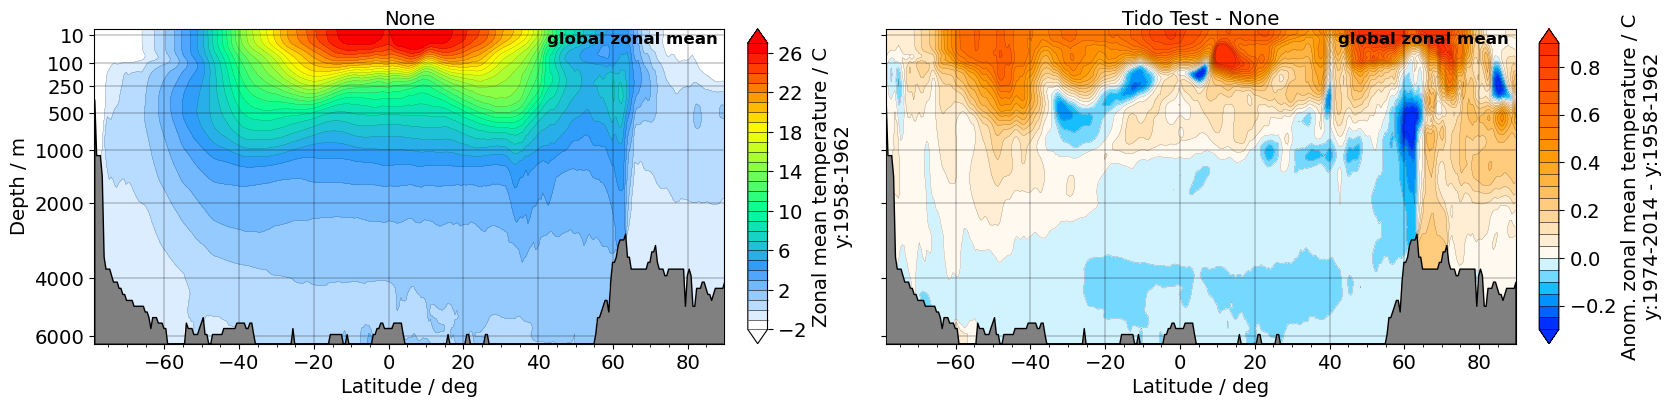

 --> elasped time to plot data: 0.02 min.


In [17]:
#___PLOT ZONMEAN TRANSECT______________________________________________________________________________
ts = clock.time()
nbox, ndat = len(box), len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')

for box_idx in range(nbox):
    svname = list(data_list[0][box_idx].data_vars)[0]
    slabel = data_list[0][box_idx][svname].attrs['str_lsave']
    stname = data_list[0][box_idx][svname].attrs['transect_name'].replace(' ','_').lower()
    #__________________________________________________________________________________________________
    # do save filename path
    spath  = save_path
    sfpath = None
    if spath!=None: 
        sfpath=list()
        for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'zonmean', stname ,slabel, sfmt)) )
    if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
    
    #__________________________________________________________________________________________________
    # do colorbar either single cbar or ref_cbar + anom_cbar
    if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
    else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
    
    #__________________________________________________________________________________________________    
    hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=nrow0, ncol=ncol0, box_idx=box_idx, 
                                     cinfo=cinfo0, do_rescale=do_rescale,  
                                     do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                     ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                     cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                     do_save=sfpath, save_dpi=save_dpi )    

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 

In [7]:
if do_papermill and do_parallel and client is not None: client.shutdown()